In [6]:
from data_loader import LakesDataset
import torch
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
batch_size = 50

train_dataset =LakesDataset(train=True)
test_dataset =LakesDataset(train=False)

# DataLoader, Transformation

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
                                           shuffle=False)

examples=iter(test_loader)

samples, labels = next(examples)
print(samples.shape, labels.shape)


torch.Size([50, 3, 1024, 1024]) torch.Size([50, 1, 1024, 1024])


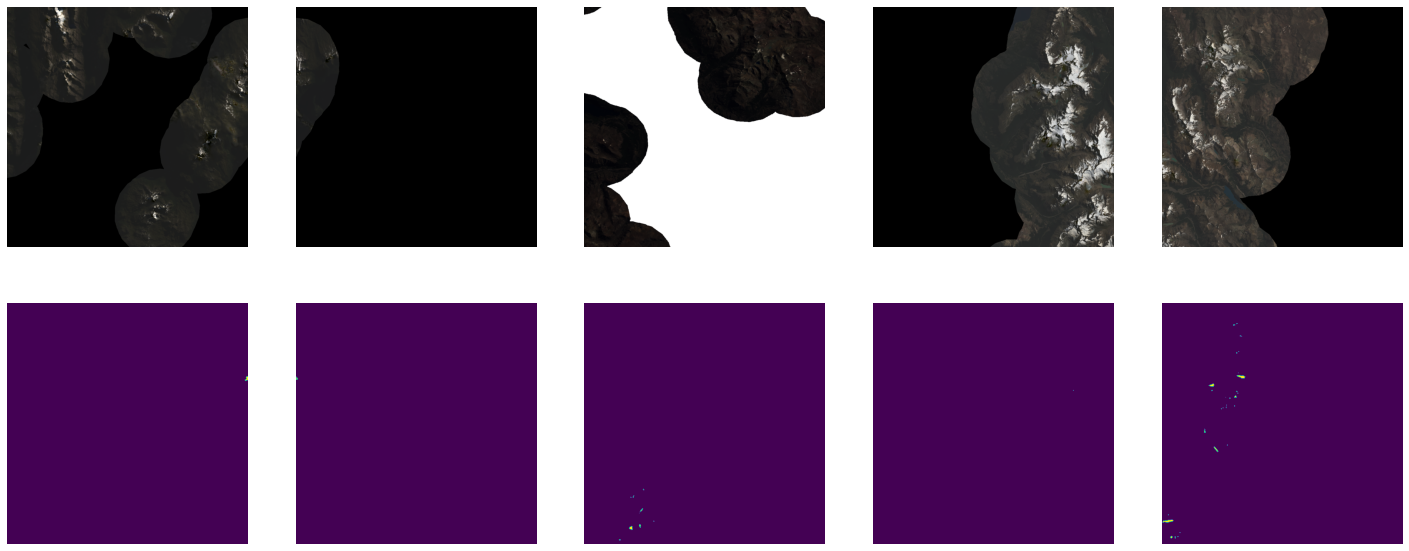

In [24]:
plt.figure(figsize=(25, 10))
for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(samples[15+i].permute(1,2,0))
    plt.axis("off")
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(labels[15+i].permute(1,2,0))
    plt.axis("off")

In [39]:
import os
path = 'data/train/'
imgs = (os.listdir(path + 'images')[5:10])
lbls = (os.listdir(path + 'labels')[5:10])

In [40]:
def normalize(array):
        """Normalizes numpy arrays into scale 0.0 - 1.0"""
        array_min, array_max = array.min(), array.max()
        return ((array - array_min)/(array_max - array_min))

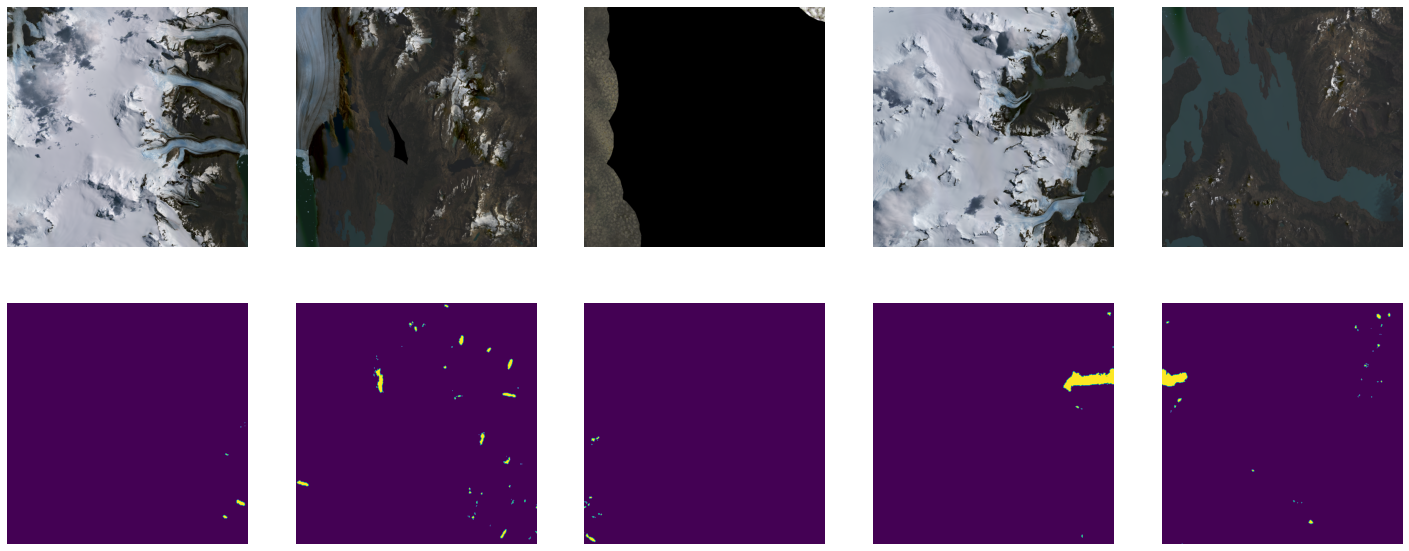

In [41]:
import rasterio
import numpy as np

plt.figure(figsize=(25, 10))
for i in range(5):
    img = rasterio.open(path + 'images/' + imgs[i])
    lbl = rasterio.open(path + 'labels/' + lbls[i])

    img = (np.dstack((normalize(img.read(1)), normalize(img.read(2)), normalize(img.read(3)))))
    lbl = (normalize(lbl.read(1)))

    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(lbl)
    plt.axis("off")
